# Packages

In [13]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import miceforest as mf
import re

# Functions

In [14]:
# Function to clean column names
def clean_column_names(column_names):
    clean_names = []
    for name in column_names:
        clean_name = re.sub(r'\s+', '_', name)  # Replace spaces with underscores
        clean_name = re.sub(r'[{}\[\]:,]', '', clean_name)  # Remove {, }, [, ], :, and ,
        clean_names.append(clean_name)
    return clean_names

# Preprocessing

In [15]:
meteorological = pd.read_csv('MeteorologicalDataFull.csv', encoding = 'utf-8')
basisAnalytik = pd.read_csv('BasisAnalytikMerged.csv', delimiter=';', encoding = 'utf-8')

In [16]:
# Format date column

meteorological['Date'] = pd.to_datetime(meteorological['Date'], format='%d/%m/%Y')
meteorological['Date'] = pd.to_datetime(meteorological['Date'].dt.strftime('%d-%m-%Y'), dayfirst=True)

basisAnalytik['Date'] = pd.to_datetime(basisAnalytik['Date'], format='%Y-%m-%d')
basisAnalytik['Date'] = pd.to_datetime(basisAnalytik['Date'].dt.strftime('%d-%m-%Y'), dayfirst=True)

In [17]:
# Subset datasets for dates available in the meteorological dataset

filtered_basisAnalytik = basisAnalytik.loc[
    (basisAnalytik['Date'] >= '1982-01-15') & (basisAnalytik['Date'] <= '2010-10-15')
]

filtered_meteorological = meteorological.loc[
    (meteorological['Date'] >= '1982-01-15') & (meteorological['Date'] <= '2010-10-15')
]

filtered_meteorological.reset_index(inplace=True, drop=True)

## Missing Values (Columns)

### BasisAnalytik Dataset

In [18]:
# Threshold of NAs for dropping columns (25%)
threshold = 0.25

# Calculate the percentage of missing values for each column
missing_percentage = filtered_basisAnalytik.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index

# Drop columns from the original DataFrame
filtered_basisAnalytik_new = filtered_basisAnalytik.drop(columns=columns_to_drop)

print("Columns dropped along with their percentage of missing values:")
for column in columns_to_drop:
    percentage = missing_percentage[column]
    print(f"{column}: {percentage * 100:.2f}%")

Columns dropped along with their percentage of missing values:
Al filt. [µg/l]: 100.00%
NH3-N [µg/l]: 73.99%
Ca filt. [mg/l]: 100.00%
Fe filt. [mg/l]: 100.00%
DOC [mg/l]: 89.60%
K filt. [mg/l]: 100.00%
Mg filt. [mg/l]: 100.00%
Mn filt. [mg/l]: 100.00%
Na filt. [mg/l]: 100.00%
NO3 [mg/l]: 73.41%
NO2-N [mg/l]: 80.06%
P-ges. filt. [mg/l]: 97.11%
SO4 [mg/l]: 26.88%
KS 4,3 [mmol/l]: 52.89%


### Meteoroligical Dataset

In [19]:
# Check whether meteorological dataset has NAs

missing_percentage = filtered_meteorological.isnull().mean() * 100
missing_df = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})

missing_df

,Column,Missing Percentage
0,Date,0.0
1,Air Temperature,0.0
2,Relative Humidity (x100%),0.0
3,Precipitation (mm),0.0
4,Radiation (W/m²),0.0
5,River Discharge (m³/s),0.0


## Distribution Plots

### BasisAnalytik Dataset

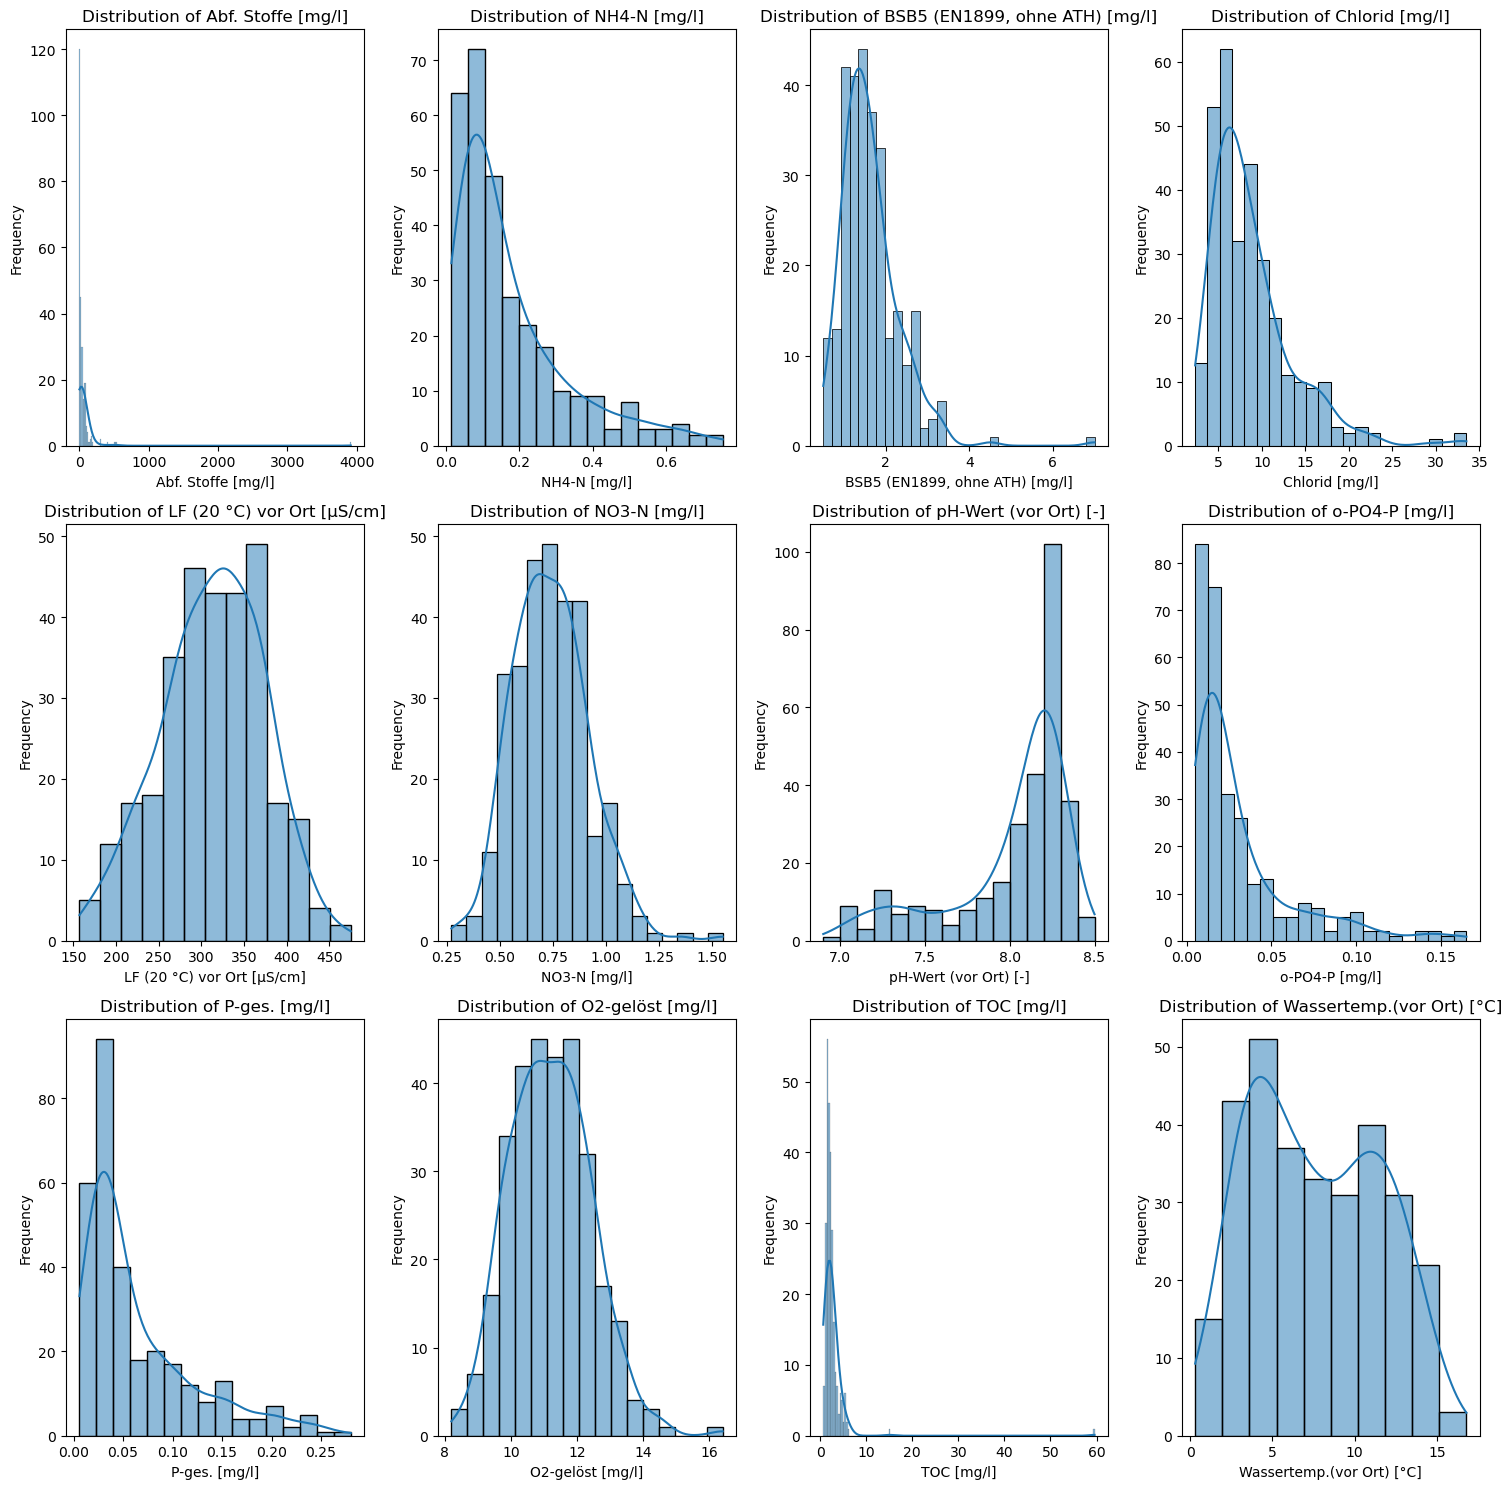

In [20]:
# Handle missing values and convert non-numeric values to NaN
numeric_columns = filtered_basisAnalytik_new.drop(columns=['Date']).apply(pd.to_numeric, errors='coerce')

# Set up the subplots in a grid
num_cols = 4
num_rows = int((len(numeric_columns.columns) + num_cols - 1) / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes if there is more than one row
axes = axes.flatten()

# Visualize the distribution of numeric columns, ignoring NAs and "< BG"
for i, column in enumerate(numeric_columns.columns):
    plt.sca(axes[i])
    
    # Filter out NAs and "< BG"
    values_to_plot = numeric_columns[column].dropna().replace('< BG', pd.NA).dropna()

    sns.histplot(values_to_plot, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Distributions of "Abf. Stoffe", and "TOC" are extremely skewed. Rest are either normal or slightly skewed.

### Meteorological Dataset

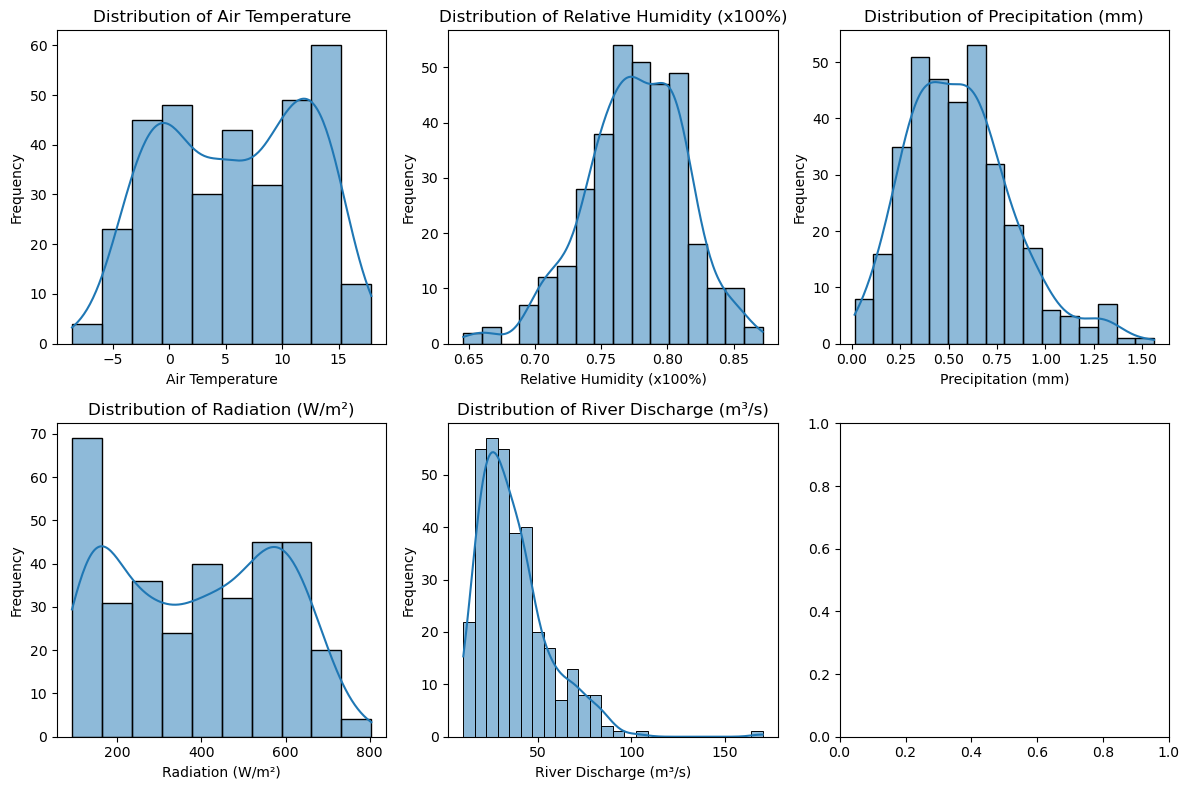

In [21]:
# Drop 'Date' column and convert remaining columns to numeric
numeric_columns_another = filtered_meteorological.drop(columns=['Date']).apply(pd.to_numeric, errors='coerce')

# Set up the subplots in a grid
num_cols_another = 3  # Assuming 3 columns in the new dataset
num_rows_another = int((len(numeric_columns_another.columns) + num_cols_another - 1) / num_cols_another)
fig_another, axes_another = plt.subplots(num_rows_another, num_cols_another, figsize=(12, 8))

# Flatten the axes if there is more than one row
axes_another = axes_another.flatten()

# Visualize the distribution of numeric columns, ignoring NAs and "< BG"
for i, column_another in enumerate(numeric_columns_another.columns):
    plt.sca(axes_another[i])
    
    # Filter out NAs and "< BG"
    values_to_plot_another = numeric_columns_another[column_another].dropna().replace('< BG', pd.NA).dropna()

    sns.histplot(values_to_plot_another, kde=True)
    plt.title(f'Distribution of {column_another}')
    plt.xlabel(column_another)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### BasisAnalytik Dataset Timeseries Plots

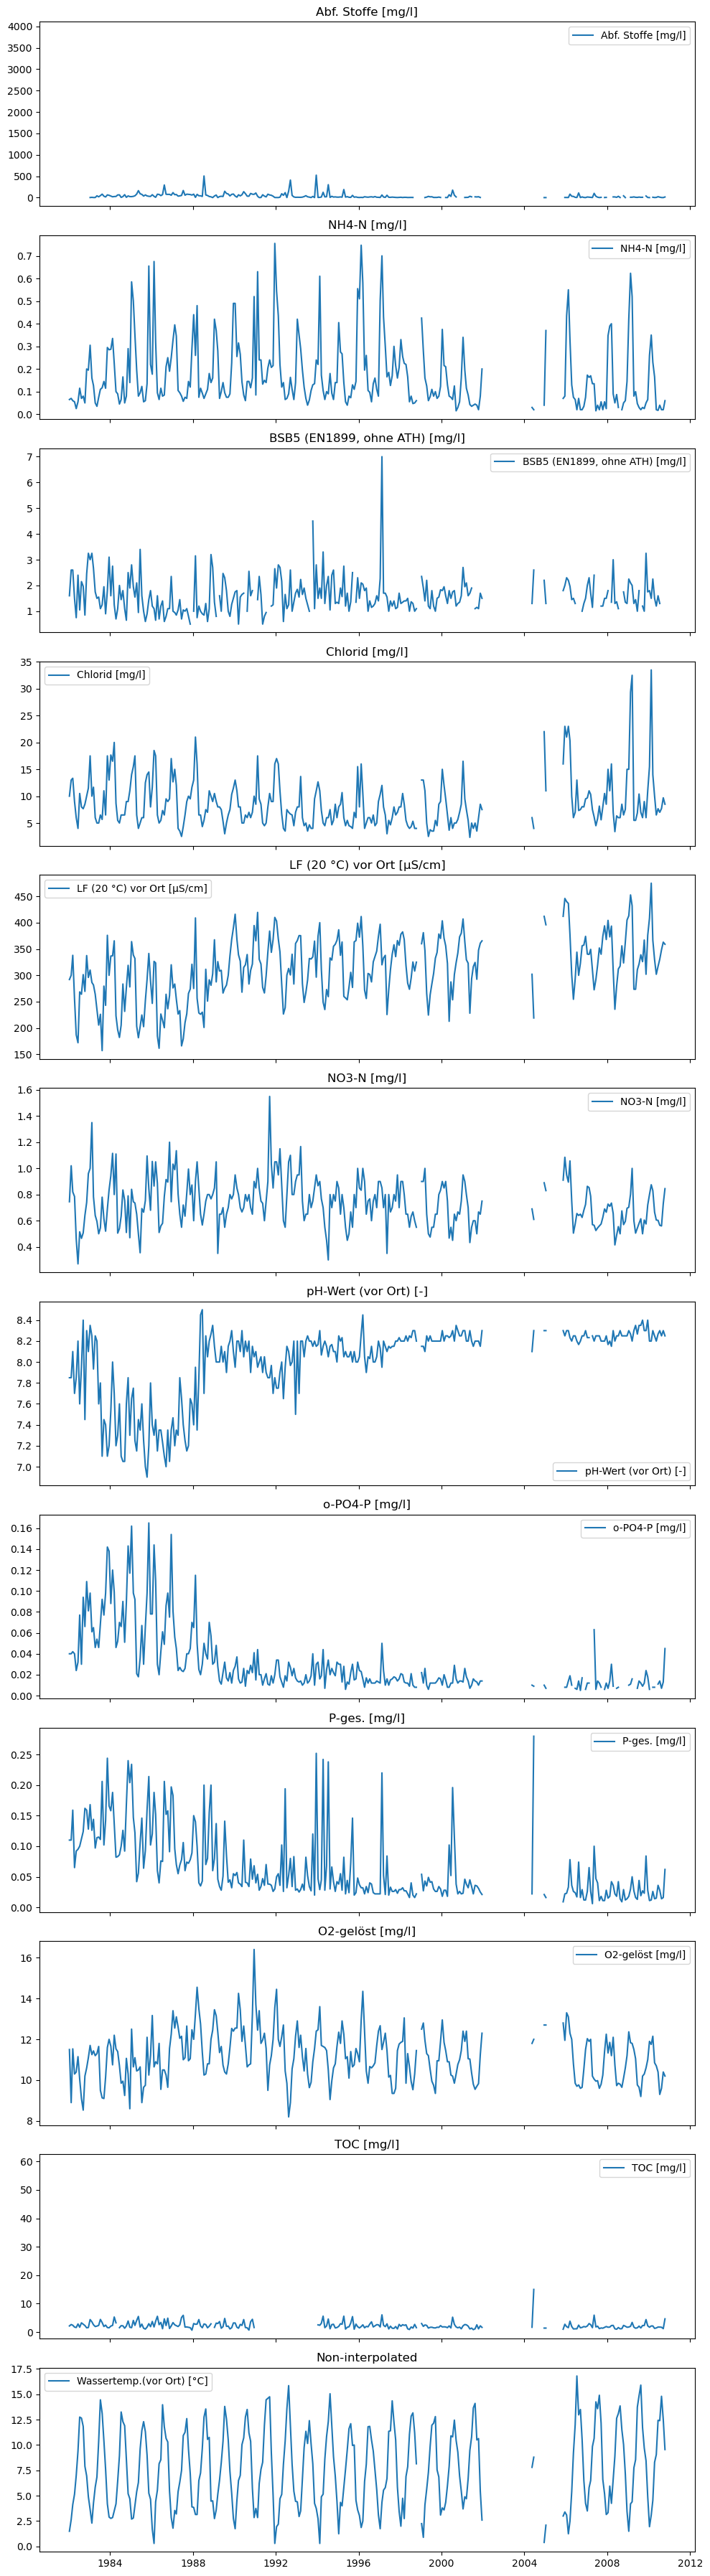

In [22]:
# To get a better understanding of which interpolation method should be used plot features

df_dateindex = filtered_basisAnalytik_new.set_index('Date')

df_dateindex = df_dateindex.apply(pd.to_numeric, errors='coerce')

num_variables = len(df_dateindex.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 3), sharex=True)

if num_variables == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for i, column in enumerate(df_dateindex.columns):
    ax = axes[i]
    ax.plot(df_dateindex.index, df_dateindex[column], label=str(column))
    ax.set_title(str(column))
    ax.legend(loc='best')

plt.tight_layout()
plt.title('Non-interpolated')
plt.show()

## Interpolation

In [23]:
df_dateindex.columns = clean_column_names(df_dateindex.columns)

# Convert your DataFrame into a MiceForest Kernel
kernel = mf.ImputationKernel(
    df_dateindex,
    save_all_iterations=True,
    random_state=1991
)

kernel.mice(20)  # Number of iterations

# Generate the completed dataset
completed_data = kernel.complete_data()
completed_data = completed_data.round(3)


In [24]:
print(completed_data.isna().sum()) 
basisAnalytik = completed_data.reset_index()

Abf._Stoffe_mg/l               0
NH4-N_mg/l                     0
BSB5_(EN1899_ohne_ATH)_mg/l    0
Chlorid_mg/l                   0
LF_(20_°C)_vor_Ort_µS/cm       0
NO3-N_mg/l                     0
pH-Wert_(vor_Ort)_-            0
o-PO4-P_mg/l                   0
P-ges._mg/l                    0
O2-gelöst_mg/l                 0
TOC_mg/l                       0
Wassertemp.(vor_Ort)_°C        0
dtype: int64


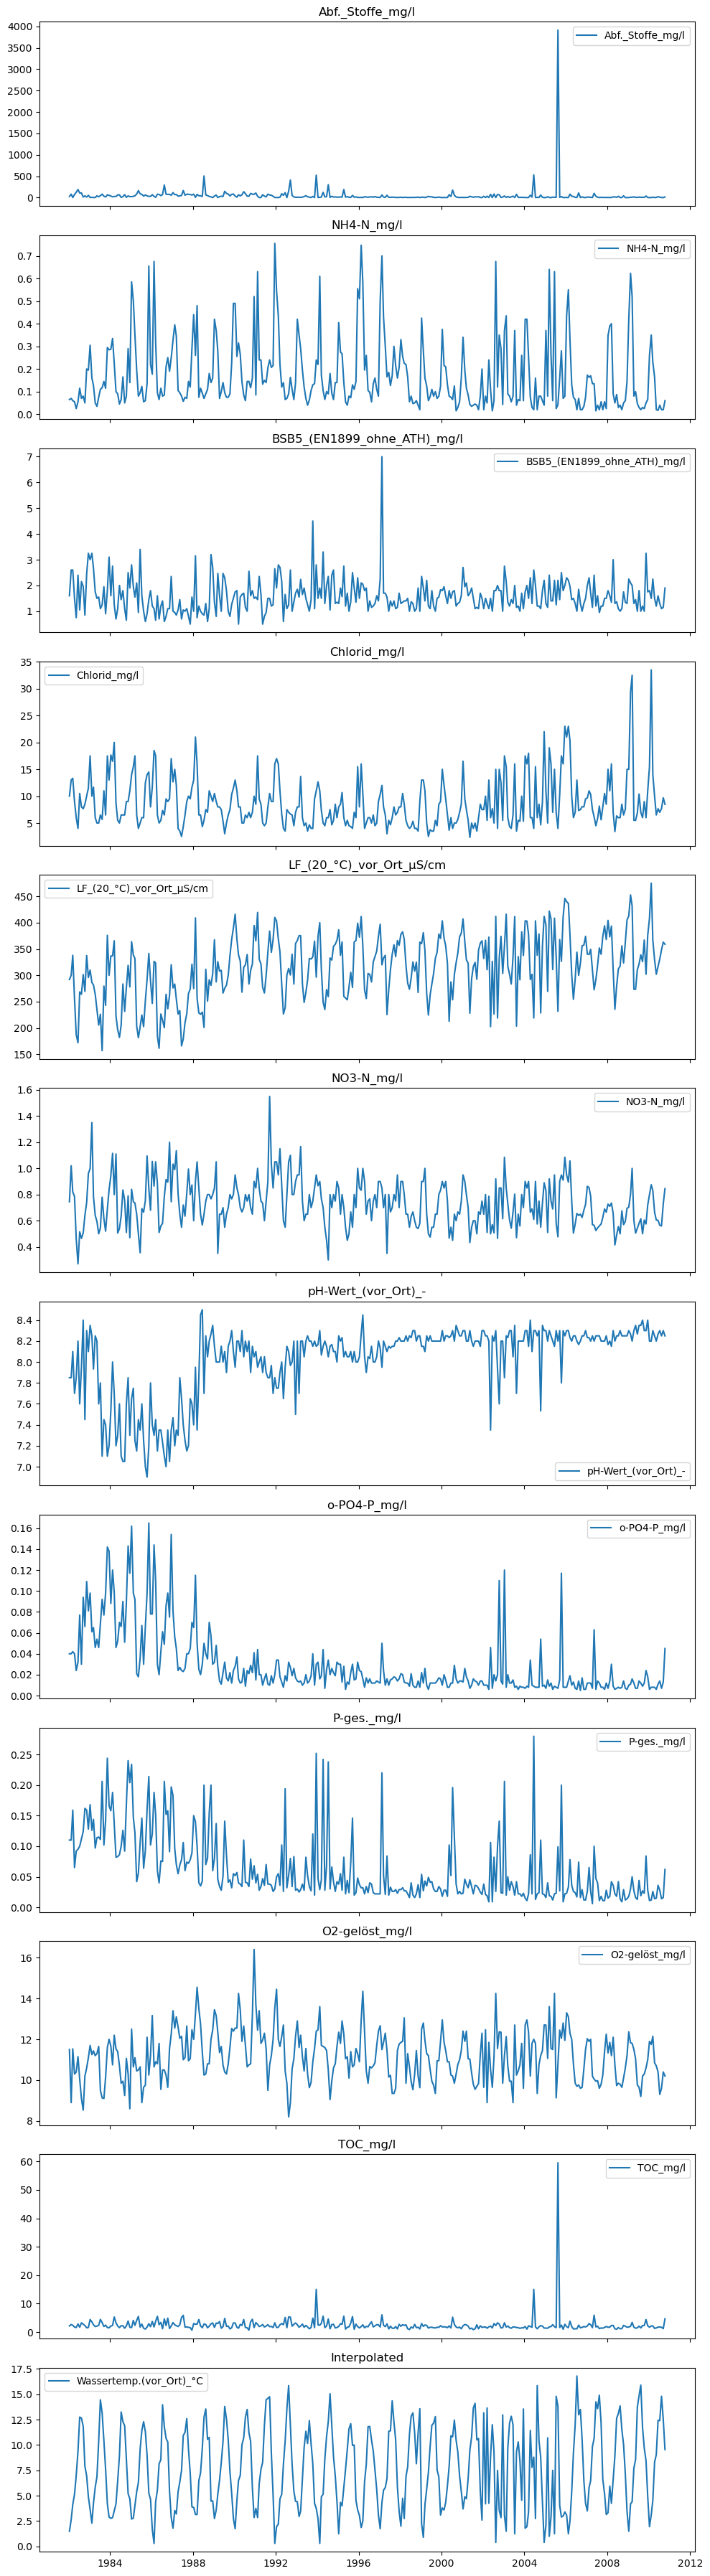

In [25]:
num_variables = len(completed_data.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 3), sharex=True)

if num_variables == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for i, column in enumerate(completed_data.columns):
    ax = axes[i]
    ax.plot(completed_data.index, completed_data[column], label=str(column))
    ax.set_title(str(column))
    ax.legend(loc='best')

plt.tight_layout()
plt.title('Interpolated')
plt.show()

# Store

In [26]:
# Store filtered Meteorological dataset & filtererd + preprocessed BasisAnalytik dataset

basisAnalytik.to_csv('BasisAnalytikInterpolated.csv', encoding='utf-8', index=False)
filtered_meteorological.to_csv('MeteorologicalFiltered.csv', encoding='utf-8', index=False)